<a href="https://colab.research.google.com/github/jinoh5/disentangled/blob/main/find_nondisentangled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## INPUT

In [1]:
import scipy
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

In [2]:
# parameters
sigma = 1
N = 20
T = 100
numCond = 4
noise_var = 2

In [3]:
# original condition
org_cond = np.zeros((4,2))
org_cond[1,:] = [1,0]
org_cond[2,:] = [1,1]
org_cond[3,:] = [0,1]

The Rank of a Matrix:  4


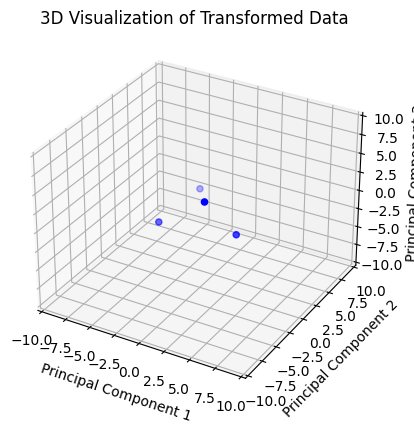

The Rank of a Matrix:  3


In [4]:
# Use Gaussian to find the
subInput_non = np.random.normal(loc=0, scale=sigma, size=[numCond,N])
print("The Rank of a Matrix: ", np.linalg.matrix_rank(subInput_non))

# Let's look at the structure (make sure the four points are not on the same plane)
pca = PCA(n_components = 3)

transformed_data = pca.fit_transform(subInput_non)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the transformed data
ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c='b', marker='o')

# Set labels and title (axis is important)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Visualization of Transformed Data')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])

plt.show()

print("The Rank of a Matrix: ", np.linalg.matrix_rank(transformed_data))

In [5]:
# Step 3 - add noise
input_nondis = np.zeros((numCond,T,N))

for i in range(4):
    input_nondis[i,:,:] = np.tile(subInput_non[i,:], (100, 1))

# add very small Gaussian noise
noise_matrix = np.random.normal(loc=0, scale=noise_var, size=input_nondis.shape)
input_w_noise = input_nondis + noise_matrix

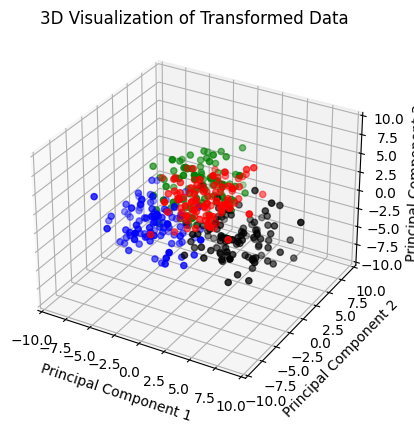

In [6]:
# reshape
input = np.vstack((input_w_noise[0,:,:], input_w_noise[1,:,:], input_w_noise[2,:,:], input_w_noise[3,:,:]))

# PCA
pca = PCA(n_components = 3)
transformed_data = pca.fit_transform(input)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the transformed data
for _, (idx, color) in enumerate(zip(range(4), ['r','g','b','k'])):
    ax.scatter(transformed_data[idx*100:(idx+1)*100, 0],
               transformed_data[idx*100:(idx+1)*100, 1],
               transformed_data[idx*100:(idx+1)*100, 2],
               c=color, marker='o')

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Visualization of Transformed Data')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])

plt.show()

##Build Network

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset

In [8]:
# Experiment conditions
task1 = org_cond[:,0]
task2 = org_cond[:,1]
xor = np.sum(org_cond,axis=1)%2

In [9]:
# Model 1 (nonlinear classifier)
class Simple_Nonlin(nn.Module):

  def __init__(self, input_dim, hidden_dim, output_dim):
    super(Simple_Nonlin, self).__init__()

    self.input_layer = nn.Linear(input_dim, hidden_dim)
    self.hidden_layer = nn.Linear(hidden_dim, output_dim) # here, I can add noise to make noises in the hidden layer

  def forward(self, x):
    x = F.relu(self.input_layer(x)) # Applying ReLU activation after input_layer
    x = self.hidden_layer(x) # currently does not have softmax activation (But F.softmax is possible depending on the model)
    # x = F.log_softmax(self.hidden_layer(x), dim=1)
    return x

In [10]:
# Model 2 (linear classifier)
class Simple_lin(nn.Module):

  def __init__(self, input_dim, hidden_dim, output_dim):
    super(Simple_lin, self).__init__()
    self.input_layer = nn.Linear(input_dim, output_dim)

  def forward(self, x):
    y = self.input_layer(x)
    return y

In [11]:
def run_simple(expname, exp_cond, n_trials_perpoint, input, input_dim, output_dim, modelName, batchsize, num_epochs, learning_rate):

  # Experiment target
  target = np.repeat(exp_cond, n_trials_perpoint)

  input_tensor = torch.tensor(input, dtype=torch.float32)
  target_tensor = torch.tensor(target, dtype=torch.long)

  # Create a TensorDataset and DataLoader
  dataset = TensorDataset(input_tensor, target_tensor)

  # Define the size of train and test sets
  train_size = int(0.8 * len(dataset))
  test_size = len(dataset) - train_size

  # Split the dataset
  train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

  # Create train and test dataloaders
  train_loader = DataLoader(train_dataset, batch_size = batchsize, shuffle=True) # shuffle the training dataset every time it starts a new epoch
  test_loader = DataLoader(test_dataset, batch_size = batchsize, shuffle=False)

  # hidden dim
  hidden_dim = input_dim * 2

  # Create an instance of a model
  model = modelName(input_dim, hidden_dim, output_dim)
  print(model)

  # Loss function and optimizer
  lossfun = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = learning_rate) # this is where I will add regularization metrics

  # Training loop
  trainLosses = []
  valLosses = []
  accuracies = []

  for epoch in range(num_epochs): # for every epoch

    # train set up
    model.train()
    train_loss = 0 # for every epoch, the loss is added across all batches

    for inputs, targets in train_loader: # During each epoch's training loop, when you iterate through 'train loader'
                                        # the batches ('inputs' and 'targets') are provided in a shuffled order.
                                        # this means that the order of data samples within each batch is randomized compared to the previous epoch

      inputs = inputs.float()

      # clear the gradients
      optimizer.zero_grad()

      # Apply the model
      output = model(inputs)

      # Compute the loss
      loss = lossfun(output, targets)

      # Backpropagation
      loss.backward()

      # Update the weights
      optimizer.step()

      # Add loss
      train_loss += loss.item()

    # Just showing how it increments
    # if (epoch+1) % 1 == 0:
    #   print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')

    avg_train_loss = train_loss / len(train_loader)
    trainLosses.append(avg_train_loss)

  # Evaluation phase
  # Can the loss decrease even if the accuracy is not good?

    model.eval()
    val_loss = 0
    total = 0
    correct = 0

    with torch.no_grad(): # no need to track gradients during evaluation

      for inputs, targets in test_loader:

        # test input
        testoutput = model(inputs)

        # find the validation loss
        loss = lossfun(testoutput, targets)
        val_loss += loss.item()

        # Get the max output?
        _, predicted = torch.max(testoutput, 1)

        # print("targets", targets)
        # print("predicted", predicted)

        # store the result
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      accuracy = correct / total
      accuracies.append(accuracy)

    # Average validation loss for this epoch
    avg_val_loss = val_loss / len(test_loader)
    valLosses.append(avg_val_loss)

    if (epoch+1) % 1 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(test_loader):.4f}')


  # Plot train loss and validation loss and accuracy
  epoch_nums = np.arange(num_epochs)+1

  fig, axs = plt.subplots(1,2, figsize=(12,5))

  axs[0].plot(epoch_nums, trainLosses, 'r')
  axs[0].plot(epoch_nums, valLosses, 'b')
  axs[0].set_title("Loss")
  axs[0].set_xlabel("Epoch num")
  axs[0].set_ylabel("Loss")
  axs[0].legend(['Train loss', 'Validation loss'])
  axs[0].set_ylim([0, 1])

  axs[1].plot(epoch_nums, accuracies, 'g')
  axs[1].set_title("Accuracy")
  axs[1].set_xlabel("Epoch num")
  axs[1].set_ylabel("Accuracy")
  axs[1].set_ylim([0, 1])

  if modelName == Simple_Nonlin:
      plt.suptitle("Nonlinear classifier: " + str(expname))
  elif modelName == Simple_lin:
      plt.suptitle("Linear Classifier: " + str(expname))

  plt.tight_layout()
  plt.show()

Simple_Nonlin(
  (input_layer): Linear(in_features=20, out_features=40, bias=True)
  (hidden_layer): Linear(in_features=40, out_features=2, bias=True)
)
Epoch [1/70], Training Loss: 0.7059, Validation Loss: 0.7356
Epoch [2/70], Training Loss: 0.5710, Validation Loss: 0.6783
Epoch [3/70], Training Loss: 0.4888, Validation Loss: 0.6372
Epoch [4/70], Training Loss: 0.4343, Validation Loss: 0.6004
Epoch [5/70], Training Loss: 0.3871, Validation Loss: 0.5773
Epoch [6/70], Training Loss: 0.3506, Validation Loss: 0.5528
Epoch [7/70], Training Loss: 0.3216, Validation Loss: 0.5329
Epoch [8/70], Training Loss: 0.2973, Validation Loss: 0.5212
Epoch [9/70], Training Loss: 0.2790, Validation Loss: 0.5069
Epoch [10/70], Training Loss: 0.2616, Validation Loss: 0.5000
Epoch [11/70], Training Loss: 0.2481, Validation Loss: 0.4919
Epoch [12/70], Training Loss: 0.2376, Validation Loss: 0.4793
Epoch [13/70], Training Loss: 0.2246, Validation Loss: 0.4813
Epoch [14/70], Training Loss: 0.2149, Validation L

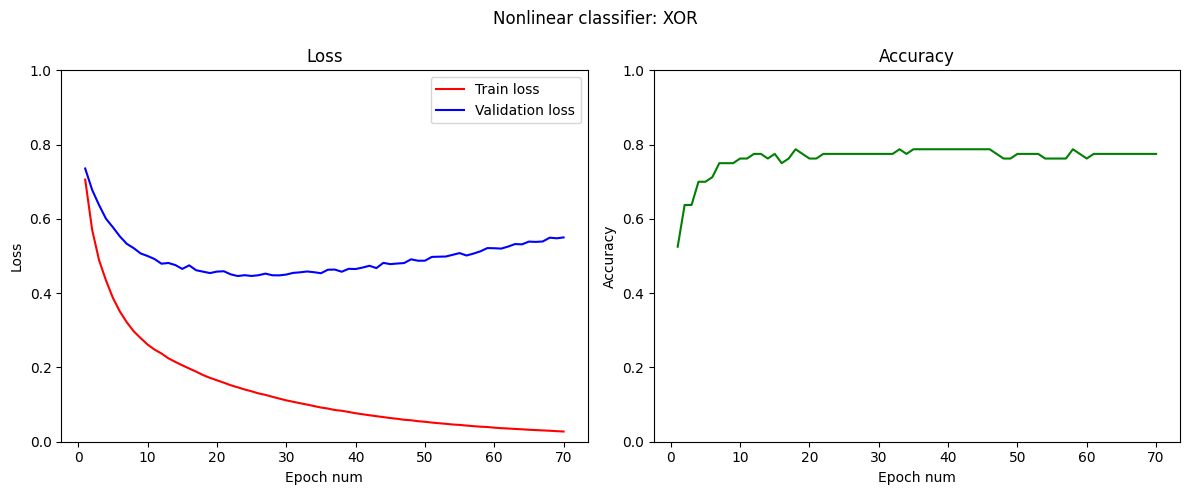

In [12]:
run_simple(expname = "XOR",
           exp_cond = xor,
           n_trials_perpoint = 100,
           input = input,
           input_dim = 20,
           output_dim = 2,
           modelName = Simple_lin, #Simple_Nonlin,
           batchsize = 20,
           num_epochs = 70,
           learning_rate = 0.001)